In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
sample_submission = pd.read_csv('original_data/sample_submission.csv')
test_features = pd.read_csv('original_data/test_features.csv')
train_features = pd.read_csv('original_data/train_features.csv')
train_labels = pd.read_csv('original_data/train_labels.csv')

# Data cleanup
I don't want to start out by using all the features available, as several of them are probably useless and require lots of cleanup.  So I'll create several cleanup functions that extract different subsets of the features.  I write them as functions so that I can easily apply them to the training and testing data equally.  This way, also, I don't need to commit to a particular set of features ahead of time.

In [3]:
def cleanup1(X):
    """
    Minimal viable cleaning.
    
    This function gets the data in minimal working order for a logistic 
    regression. I fill up NANs (which appear only in the categorcial
    features), change datetime objects to numbers, drop one useless 
    feature and standardize the datatypes.
    
    Parameters
    ----------
    X : pandas.DataFrame (DF)
        Original, full-featured DF (train_features or test_features)
    
    Returns
    ----------
    X2 : pandas.DataFrame
        Cleaned DF
    """
 
    # Make a clean copy, to ensure we're not changing the original DF
    X2 = X.copy()
    
    # Looking at all the features with missing values, it looks like those
    # features are all categorical variables where 'unknown' would be a
    # category we can work with.  I'll replace the NANs accordingly.
    X2 = X2.fillna('unknown')
    
    # Regression on dates won't work.  Instead, I'll turn the 
    # date_recorded column into the number of years since 2000
    # (the earliest date in the training date is from ~2002, and the
    # latest from 2013.)
    dates = pd.to_datetime(X2.date_recorded)
    year2000 = pd.to_datetime('2000-01-01')
    years = [i.days/365 for i in (dates - year2000)]
    X2.date_recorded = years
    
    # region_code and district_code are int64, but they should really be
    # treated as categories (and there's only 20-30 classes in each).
    # I'll cast them as strings instead.
    X2.region_code = X2.region_code.astype('str')
    X2.district_code = X2.district_code.astype('str')
    
    # recorded_by has only one value everywhere, and is therefore useless
    X2 = X2.drop(columns='recorded_by')
    
    # To prevent data conversion warnings, I'll turn all the numerical
    # features (except id) into float64.
    
    # Also, some columns contained bool values and NANs.  
    # (e.g., public_meeting, permit)
    # I replaced the NANs with strings, which created a problem for later
    # operations that don't like heterogeneous datatypes within a single
    # column. I'll prevent this problem by casting those two features as str.
    
    type_dict = {'amount_tsh':'float64',
                 'date_recorded':'float64',
                 'gps_height':'float64',
                 'longitude':'float64',
                 'latitude':'float64',
                 'num_private':'float64',
                 'population':'float64',
                 'construction_year':'float64',
                 'public_meeting':'str',
                 'permit':'str'}
    
    X2 = X2.astype(dtype = type_dict)
    
    return X2

In [4]:
from sklearn.impute import MissingIndicator

def cleanup2(X):
    """
    Fixes the numerical features. 
    
    
    Each feature has different specific problems, but they usually have
    garbage values (usually zero) that should really be read as NANs.
    
    I want to fix those values, but I also want to take note of the 
    datapoints where they happened.  I do this because I assume that 
    missing values tell us something about the well that our model
    might be able to pick up later.
    
    
    Parameters
    ----------
    X : pandas.DataFrame
        DF with raw numerical features
    
    Returns
    ----------
    X2 : pandas.DataFrame
         DF with cleaned numerical features and a new matrix of former
         garbage locations within those features.
    
    """
    
    
    # Make a clean copy, to ensure we're not changing the original DF
    X2 = X.copy()
    
    # I make a list of the numerical columns and a dict of their 
    # garbage values that really should be nulls
    numericals = ['amount_tsh',
                    'date_recorded',
                    'gps_height',
                    'longitude',
                    'latitude',
                    'num_private',
                    'population',
                    'construction_year']

    null_values = {'amount_tsh':0,
                     'date_recorded':0,
                     'gps_height':0,
                     'longitude':0,
                     'latitude':-2.000000e-08,
                     'num_private':0,
                     'population':0,
                     'construction_year':0}

    # I replace all garbage values with NANs.
    for feature, null in null_values.items():
        X2[feature] = X2[feature].replace(null, np.nan)

    # construction_year occasionally claims years far in the future, and 
    # could presumably also contain years way in the past.  I'll turn anything
    # not between 1960 and 2019 into a NAN.
    X2['construction_year'] = [i if 1960 < i < 2019 else np.nan for i in X2['construction_year']]
    
    
    # Creating indicator columns.
    # ---------------------------------------------------------------
    # These columns mark the locations of all the NANs 
    # in the numericals. Note that MissingIndicator returns a numpy array.
    
    indicator = MissingIndicator()
    trash_array = indicator.fit_transform(X2[numericals]) # Bool array
    trash_array = trash_array.astype('float64')     # Float64 array

    # Create a titles for the columns in num_trashmarker
    trashy_names = [numericals[i] + '_trash' for i in indicator.features_]

    # Create num_trashmarker
    trash_df = pd.DataFrame(trash_array, columns=trashy_names)

    # I add trash_df to X2
    X2 = pd.concat([X2,trash_df], sort=False, axis=1)
    
    
    # Fixing the numerical columns.
    # ---------------------------------------------------------------
    # Whenever possible, a good replacement value for a NAN is the 
    # mean or median value for the geographic region around it.

    # Replaces the NANs in a ward with the mean of the other rows in that 
    # same ward. If all the rows in a ward are NANs, though, they remain.
    for feature in numericals:
        replacements = X2.groupby('ward')[feature].transform('mean')
        X2[feature] = X2[feature].fillna(replacements)

    # Replaces the NANs in a region with the mean of the other rows in that 
    # same region (which are much larger than wards)
    for feature in numericals:
        replacements = X2.groupby('region')[feature].transform('mean')
        X2[feature] = X2[feature].fillna(replacements)
    
    # Replaces any remaining NANs with the median value for the whole dataset
    for feature in numericals:
        replacements = X2[feature].median() # Single number, not array
        X2[feature] = X2[feature].fillna(replacements)
    
    return X2

In [12]:
def cleanup3(X):
    """
    Fixes the categorical features. 
    
    
    Each feature has different specific problems, but they usually have
    garbage values (usually 'unknown') that should really be read as NANs.
    
    This function cleans up garbage, clusters together different labels
    that should be equivalent but are coded differently (e.g., different
    spellings of the same thing), and removes labels with so few members
    that they're unlikely to be informative.
    
    
    Parameters
    ----------
    X : pandas.DataFrame
        DF with raw categorical features, except for the changes
        already included in cleanup1.
    
    Returns
    ----------
    X2 : pandas.DataFrame
         DF with cleaned categorical features.
    
    """
    
    # Make a clean copy, to ensure we're not changing the original DF
    X2 = X.copy()
    
    # Create list of categorical features
    categoricals = X2.select_dtypes(exclude='number').columns.tolist()

    # Make all strings lowercase, to collapse together some of the categories
    X2[categoricals] = X2[categoricals].applymap(lambda x: x.lower())

    # Replace common NAN values
    nan_list = ['not known','unknown','none','-','##','not kno','unknown installer']
    X2 = X2.replace(nan_list, np.nan)

    # Any feature values with fewer than 100 rows gets turned into a NAN
    for feature in X2[categoricals]:
        # Determine which feature values to keep
        to_keep = X2[feature].value_counts()[X2[feature].value_counts() > 100].index.tolist()
        # Turn those into NANs (using a copy, to prevent warnings)
        feature_copy = X2[feature].copy()
        feature_copy[~feature_copy.isin(to_keep)] = np.nan
        X2[feature] = feature_copy

    # Fix all NANs
    X2[categoricals] = X2[categoricals].fillna('other')
    
    
    return X2

## Testing cleanup steps

In [6]:
df1 = cleanup1(train_features)
df2 = cleanup2(df1)
df3 = cleanup3(df2)

In [7]:
X3 = df3.copy()

In [8]:
X3.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh_trash,gps_height_trash,longitude_trash,latitude_trash,num_private_trash,population_trash,construction_year_trash
0,69572,6000.000000,11.205479,roman,1390.000000,other,34.938093,-9.856322,other,24.876777,lake nyasa,other,iringa,11,5,ludewa,other,109.000000,true,vwc,roman,false,1999.000000,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,8776,542.857143,13.186301,other,1399.000000,other,34.698766,-2.147466,zahanati,3.857143,lake victoria,other,mara,20,2,serengeti,other,280.000000,other,other,other,true,2010.000000,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34310,25.000000,13.161644,other,686.000000,world vision,37.460664,-3.821329,other,32.395062,pangani,majengo,manyara,21,4,simanjiro,other,250.000000,true,vwc,other,true,2009.000000,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,67743,525.000000,13.084932,unicef,263.000000,unicef,38.486161,-11.155298,other,47.448276,ruvuma / southern coast,other,mtwara,90,63,nanyumbu,other,58.000000,true,vwc,other,true,1986.000000,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,19728,4043.055556,11.536986,other,1236.292754,artisan,31.130847,-1.825359,shuleni,28.788889,lake victoria,other,kagera,18,1,karagwe,other,296.596618,true,other,other,true,1987.601932,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.0,1.0,0.0,0.0,1.0,1.0,1.0


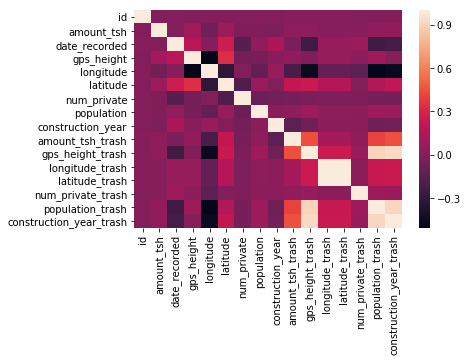

In [11]:
sns.heatmap(X3.corr());